# Fitting Gaussian Process Models in PyMC3

**Chris Fonnesbeck**  
*Vanderbilt University Medical Center*

![](images/PyMC3.jpg)

A common applied statistics task involves building regression models to characterize non-linear relationships between variables. It is possible to fit such models by assuming a particular non-linear structure, such as a sinusoidal, exponential, or polynomial function, to describe a given response by one variable to another. Unless this relationship is obvious from the outset, however, it involves possibly extensive model selection procedures to ensure the most appropriate model is retained. Alternatively, a non-parametric approach can be adopted by defining a set of knots across the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. However, knot layout procedures are somewhat *ad hoc* and can also involve variable selection. A third alternative is to adopt a **Bayesian non-parametric** strategy, and directly model the unknown underlying function. For this, we can employ Gaussian process models.

![](images/points.png)

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the fundamental first step in Bayesian modeling is to specify a *full probability model* for the problem at hand, assigning probability densities to all unknown quantities of interest. So, it is difficult to explicitly state a full probability model without the use of probability functions, which are parametric! It turns out that Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

## Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

## Sampling from a Gaussian Process

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which result in an evaluation of a function over a set of points. All we will do here is sample from the *prior* Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cmap
sns.set_context('talk')

np.random.seed(42)

def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

And this the function that implements it:

In [2]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

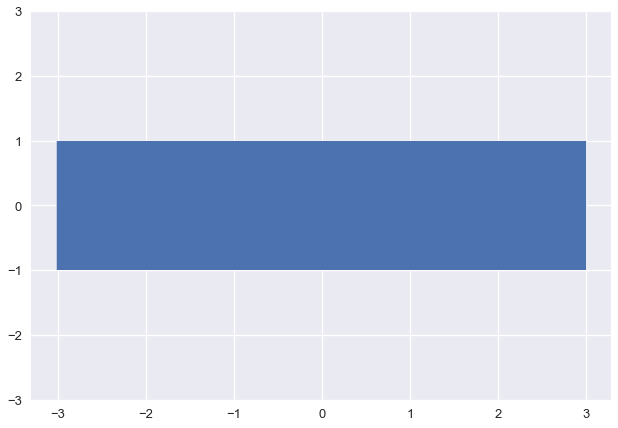

In [3]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.ylim(-3, 3);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [4]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.4967141530112327]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [5]:
σ_1 = exponential_cov(x, x, θ)

In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [7]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

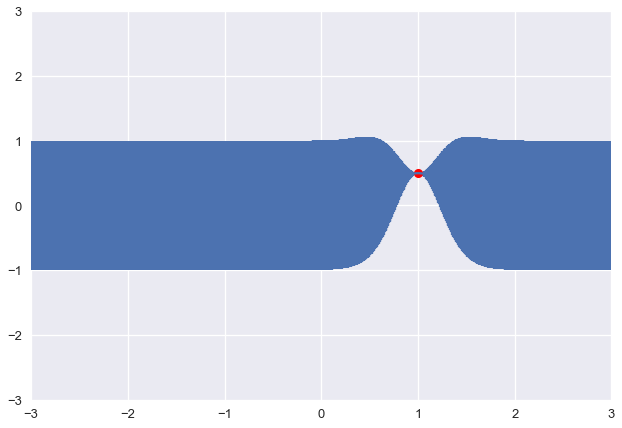

In [8]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [9]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

-0.1382640378102619

This point is added to the realization, and can be used to further update the location of the next point.

In [10]:
x.append(-0.7)
y.append(y2)

In [11]:
σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

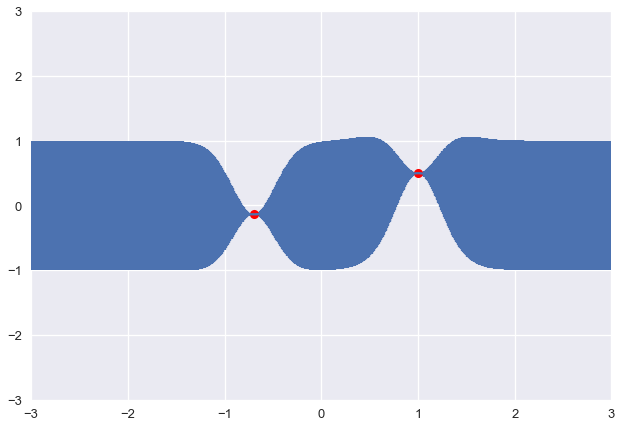

In [12]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [13]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-1.5128756 ,  0.52371713, -0.13952425, -0.93665367, -1.29343995])

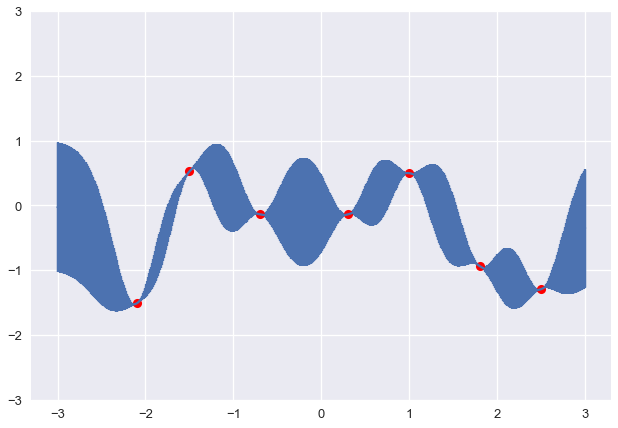

In [14]:
x += x_more
y += y_more.tolist()

σ_new = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

So as the density of points becomes high, the result will be one realization (function) from the prior GP. 

# Fitting Gaussian Processes in PyMC3

Though it's entirely possible to extend the code above to introduce data and fit a Gaussian processes by hand, there are a number of libraries available for specifying and fitting GP models in a more automated way:

- [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html)
- [GPy](https://sheffieldml.github.io/GPy/)
- [GPflow](http://gpflow.readthedocs.io/en/latest/intro.html)
- [Stan](https://mc-stan.org/)
- [Edward](edwardlib.org/)
- [GPstuff](https://github.com/gpstuff-dev/gpstuff)

I encourage you to experiment with several of these to compare their capabilities.

This talk will focus on fitting Gaussian process models in PyMC3, using both simulated and real data.

## PyMC3

The PyMC project is a very general Python package for probabilistic programming that can be used to fit nearly any Bayesian model. The current version (PyMC3) has been re-engineered from earlier versions to rely on a modern computational backend. PyMC3 is build on top of [Theano](http://deeplearning.net/software/theano/), an engine for evaluating expressions defined in terms of operations on tensors. It works in much the same way as TensorFlow, at least superficially, providing automatic differentiation, parallel computation, and dynamic generation of efficient, compiled code.

In [16]:
import pymc3 as pm
import theano.tensor as tt
import theano

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

PyMC3's feature set helps to make Bayesian analysis as painless as possible. Here is a short list of some of its features:

-   Fits Bayesian statistical models with Markov chain Monte Carlo, variational inference and
    other algorithms.
-   Includes a large suite of well-documented statistical distributions.
-   Creates summaries including tables and plots.
-   Several convergence diagnostics and model checking methods are available.
-   Extensible: easily incorporates custom step methods and unusual probability distributions.
-   MCMC loops can be embedded in larger programs, and results can be analyzed with the full power of Python.

To give you an idea of what PyMC models look like, here is a short example using a parametric survival model. This is an exponential survival model for melanoma data, taken from Bayesian Survival Analysis (Ibrahim et al 2000):

In [63]:
%run -i data/melanoma_data.py

In [62]:
from pymc3 import Normal, Model, DensityDist, sample
from pymc3.math import log, exp

with Model() as melanoma_survival:

    # Convert censoring indicators to indicators for failure event
    failure = (censored==0).astype(int)

    # Parameters (intercept and treatment effect) for survival rate
    μ = Normal('μ', 0, sd=100)
    β = Normal('β', 0, sd=100)

    # Survival rates, as a function of treatment
    lam = exp(μ + β*treat)
    
    # Survival likelihood, accounting for censoring
    def logp(failure, value):
        return (failure * log(lam) - lam * value).sum()

    x = DensityDist('x', logp, observed={'failure':failure, 'value':t})

This example will generate 1000 posterior samples.

In [64]:
with melanoma_survival:
    trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 452.49:   5%|▍         | 9564/200000 [00:00<00:15, 12637.10it/s]
Convergence archived at 10200
Interrupted at 10,200 [5%]: Average Loss = 592.63
100%|██████████| 1500/1500 [00:00<00:00, 1767.95it/s]


PyMC3 provides facilities for extracting and plotting model output:

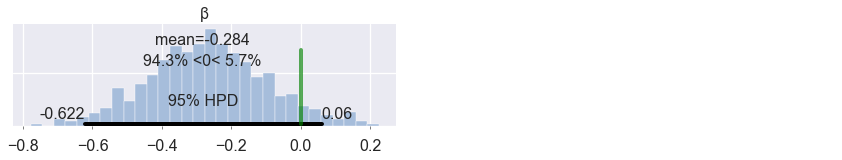

In [72]:
from pymc3 import plot_posterior

plot_posterior(trace, varnames=['β'], color='#a6bddb', ref_val=0);

## Gaussian processes in PyMC3

The following simulated data clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

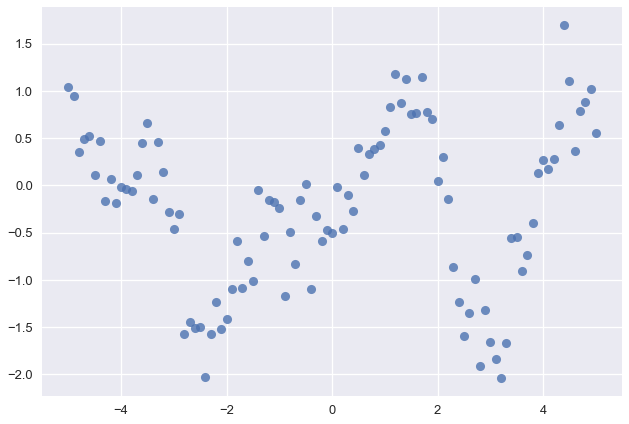

In [15]:
%run get_data.py
sns.regplot(x, y, fit_reg=False)

Along with the `fit` method, each supervised learning class retains a `predict` method that generates predicted outcomes ($y^*$) given a new set of predictors ($X^*$) distinct from those used to fit the model. For a Gaussian process, this is fulfulled by the *posterior predictive distribution*, which is the Gaussian process with the mean and covariance functions updated to their posterior forms, after having been fit. 

$$p(y^*|y, x, x^*) = \mathcal{GP}(m^*(x^*), k^*(x^*))$$

where the posterior mean and covariance functions are calculated as:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

### Covariance functions

PyMC3 includes a library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

To provide an idea regarding the variety of forms or covariance functions, here's small selection of available ones:

In [17]:
X = np.linspace(0,2,200)[:,None]

# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

### Quadratic exponential covariance

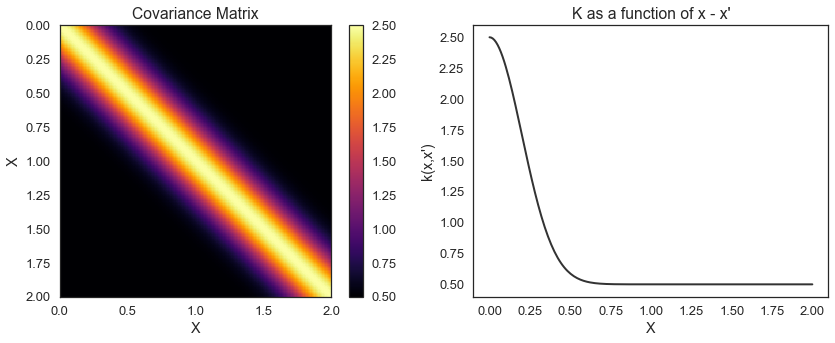

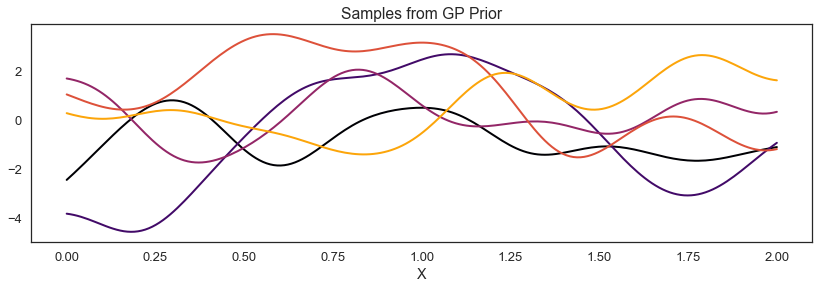

In [18]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = theano.function([], cov(X))()

plot_cov(X, K)

### Matern $\nu=3/2$ covariance

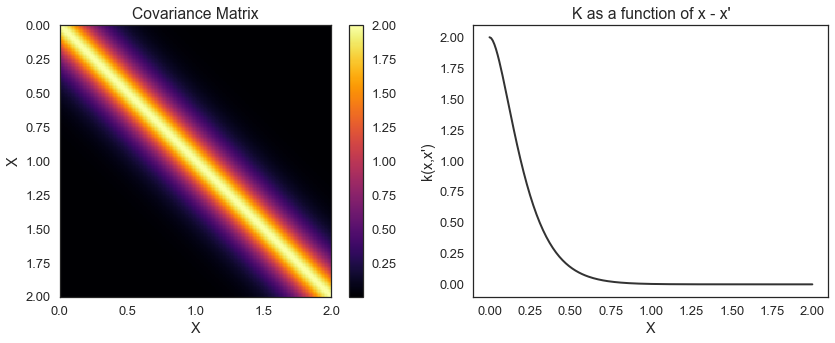

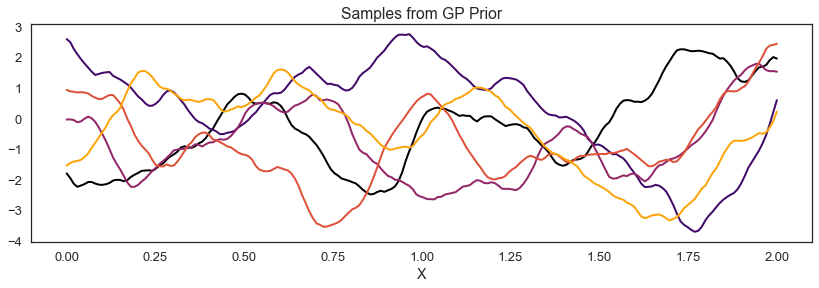

In [19]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1, l)

K = theano.function([], cov(X))()

plot_cov(X, K)

### Cosine covariance

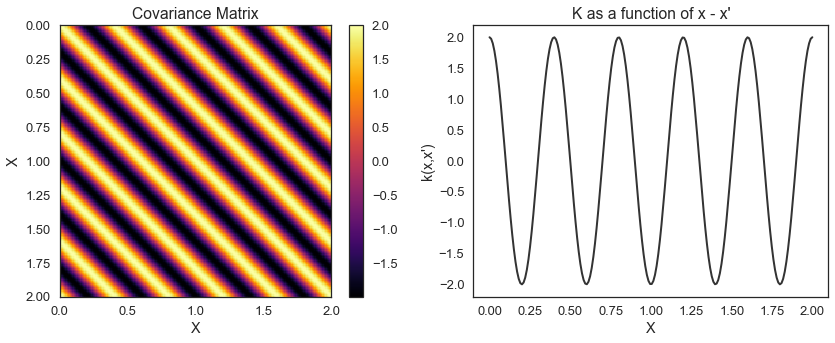

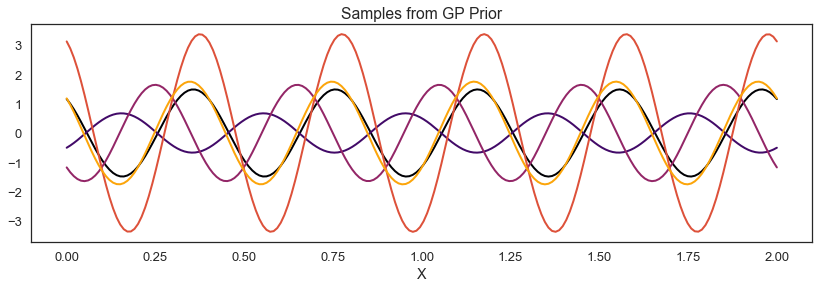

In [20]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = theano.function([], cov(X))()

plot_cov(X, K)

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

In [21]:
with pm.Model() as gp_fit:

    ρ = pm.Gamma('ρ', 1, 1)
    η = pm.Gamma('η', 1, 1)
    
    K = η * pm.gp.cov.Matern32(1, ρ) 

We can continue to build upon our model by speficying a mean function (this is redundant here, since a zero function is assumed when not specified) and an observation noise variable, which we will give a half-Cauchy prior:

In [22]:
with gp_fit:
    
    M = pm.gp.mean.Zero()
    
    σ = pm.HalfCauchy('σ', 2.5)

The Gaussian process model is encapsulated within the `GP` class, parameterized by the mean function, covariance function, and observation error specified above. Since the outcomes of the GP have been observed, we provide that data to the instance of `GP` in the `observed` argument as a dictionary. These are fed to the underlying multivariate normal likelihood.

In [23]:
X = x.reshape(-1, 1)

In [24]:
with gp_fit:
    
    y_obs = pm.gp.GP('y_obs', X=X, mean_func=M, cov_func=K, sigma2=σ**2, observed=y)

The `sample` function called inside the `Model` context fits the model using MCMC sampling. By default, PyMC3 uses an auto-tuning version of HMC called the [No U-turn Sampler](https://arxiv.org/abs/1111.4246) (NUTS) that picks appropriate values for the path length and step size parameters. Additionally, to initialize the sampler to reasonable starting parameter values, a variational inference algorithm is run before NUTS, to yield approximate posterior mean values for all the parametes.

In [25]:
with gp_fit:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 61.963:   7%|▋         | 14565/200000 [00:32<05:22, 575.25it/s]
Convergence archived at 14600
Interrupted at 14,600 [7%]: Average Loss = 92.343
100%|██████████| 2000/2000 [00:43<00:00, 46.43it/s]


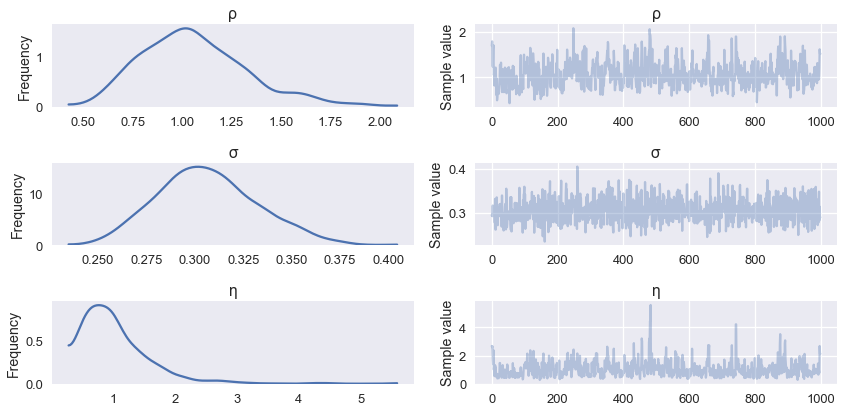

In [26]:
axes = pm.traceplot(trace, varnames=['ρ', 'σ', 'η'])

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC3 allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `sample_gp` function implements the predictive GP above, called with the sample trace, the GP variable and a grid of points over which to generate realizations:

In [27]:
Z = np.linspace(-6, 6, 100).reshape(-1, 1)
with gp_fit:
    gp_samples = pm.gp.sample_gp(trace, y_obs, Z, samples=10)

100%|██████████| 10/10 [00:06<00:00,  1.41it/s]


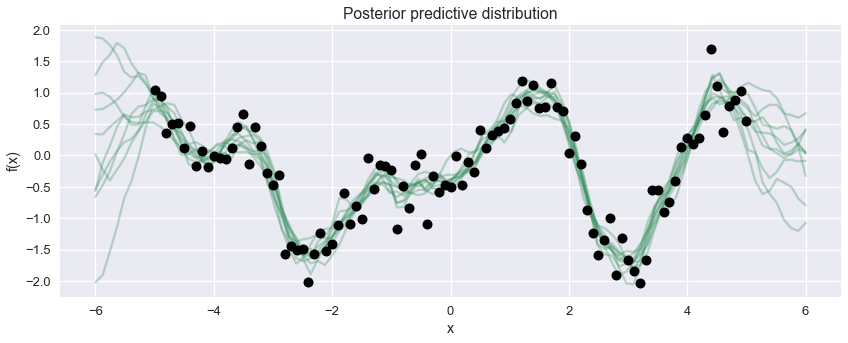

In [28]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color='SeaGreen', alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'o', color="k", ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution")

For models being fit to very large datasets, one often finds MCMC fitting to work too slowly, as the log-probability of the model needs to be evaluated at every iteration of the sampling algorithm. In these situations, it may be worth using variational inference methods, which replace the true posterior with a simpler approximation, and use optimization to parameterize the approximation so that it is as close as possible to the target distribution. Thus, the posterior is only an approximation, and sometimes an unacceptably coarse one, but is a viable alternative for many problems. Newer variational inference algorithms are emerging that improve the quality of the approximation, and these will eventually find their way into software. In the meantime, [Variational Gaussian Approximation](http://www.mitpressjournals.org/doi/abs/10.1162/neco.2008.08-07-592#.WKNwR9aZOu4) and [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788) are available now in GPflow and PyMC3, respectively.

Let's fit the same model using just variational inference (ADVI):

In [32]:
with gp_fit:
    approx = pm.fit(20000)
    trace_advi = approx.sample(1000, include_transformed=True)
    gp_samples_advi = pm.gp.sample_gp(trace_advi, y_obs, Z, samples=10)

Average Loss = 61.604: 100%|██████████| 20000/20000 [00:36<00:00, 552.89it/s]
Finished [100%]: Average Loss = 61.606


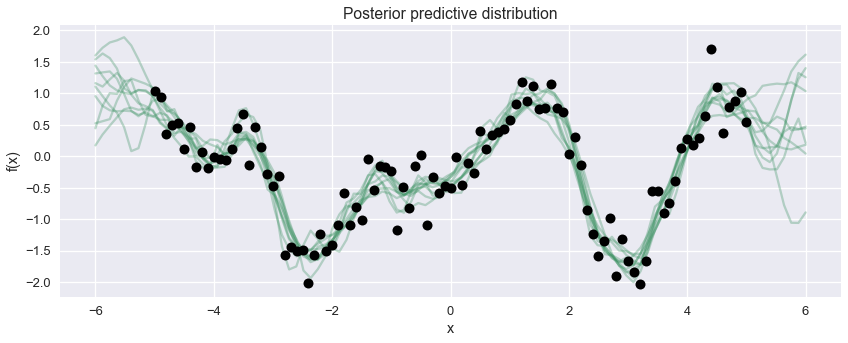

In [34]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color='SeaGreen', alpha=0.3) for x in gp_samples_advi]
# overlay the observed data
ax.plot(X, y, 'o', color="k", ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution")

### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

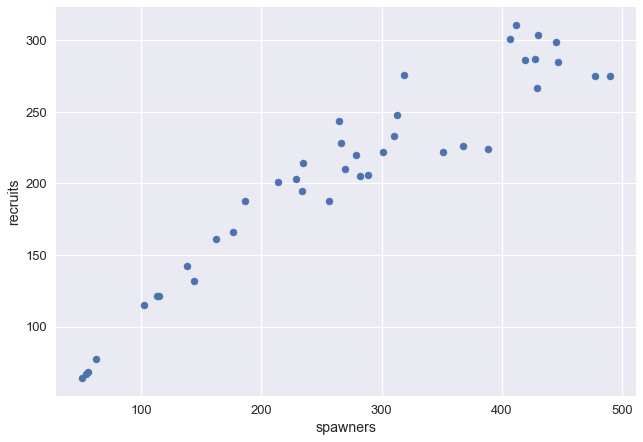

In [35]:
salmon_data = pd.read_table('data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [36]:
with pm.Model() as salmon_model:

    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = η * pm.gp.cov.Matern32(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 2.5)
    
    recruits = pm.gp.GP('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                        mean_func=M, 
                        cov_func=K, 
                        sigma2=σ**2, 
                        observed=salmon_data.recruits.values)

In [37]:
with salmon_model:
    salmon_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 220.83:   8%|▊         | 15575/200000 [00:24<06:36, 465.14it/s] 
Convergence archived at 15600
Interrupted at 15,600 [7%]: Average Loss = 1,082.1
100%|██████████| 1500/1500 [00:29<00:00, 51.10it/s]


In [38]:
salmon_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with salmon_model:
    salmon_samples = pm.gp.sample_gp(salmon_trace, recruits, salmon_pred, samples=3)

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


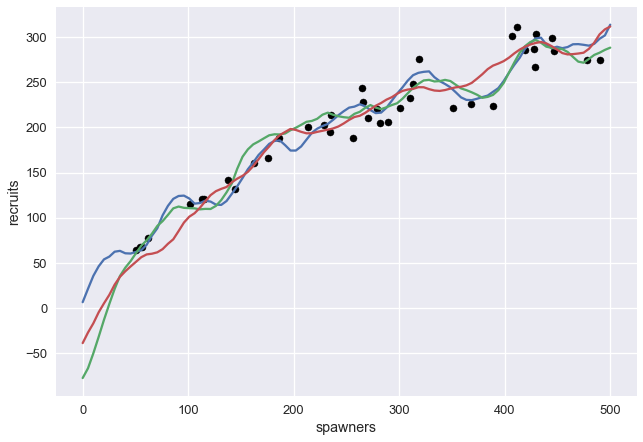

In [39]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
for x in salmon_samples:
    ax.plot(salmon_pred, x);

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed.

In [40]:
salmon_pred = np.linspace(0, 800, 100).reshape(-1, 1)
with salmon_model:
    pred = pm.gp.sample_gp(salmon_trace, recruits, salmon_pred, samples=10)

100%|██████████| 10/10 [00:08<00:00,  1.10it/s]


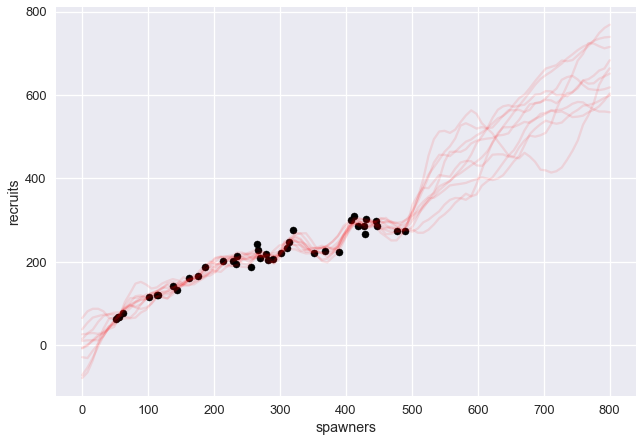

In [41]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
for x in pred:
    ax.plot(salmon_pred, x, color='r', alpha=0.1);

### Gaussian processes for classification



In [77]:
# Number of training points
n = 30
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * np.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
K_stable = K + 1e-6 * np.eye(n)

# Observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())

In [82]:
np.random.seed(42)
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_stable.eval())

# Separate data into positive and negative classes
f[f > 0] = 1
f[f <= 0] = 0

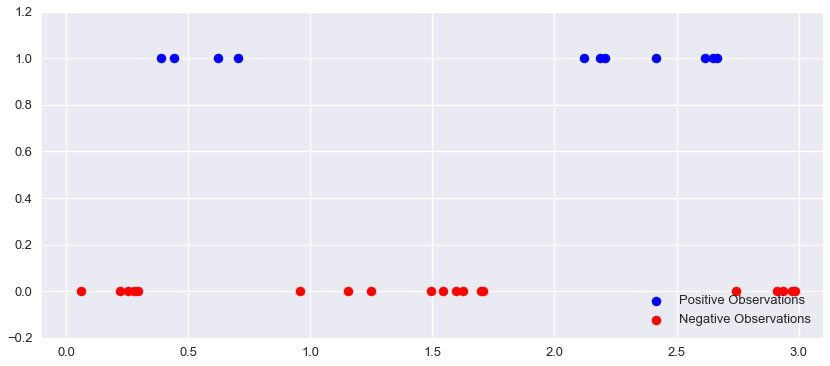

In [83]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, np.ma.masked_where(f == 0, f), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(f == 1, f), color='r', label='Negative Observations');
ax.legend(loc='lower right');
ax.set_xlim(-0.1, 3.1);
ax.set_ylim(-0.2, 1.2);

In [84]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)
    
    # Binomial likelihood
    y = pm.Binomial('y', observed=f, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step])

100%|██████████| 5500/5500 [00:14<00:00, 387.34it/s]


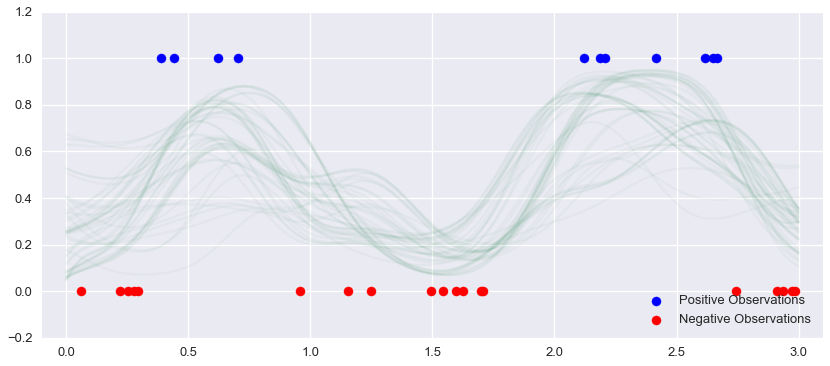

In [85]:
fig, ax = plt.subplots(figsize=(14, 6));
for ypred in trace['f_pred'][-50:]:
    ax.plot(X, ypred,  alpha=0.04, color='SeaGreen')
ax.scatter(X0, np.ma.masked_where(f == 0, f), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(f == 1, f), color='r', label='Negative Observations');
ax.legend(loc='lower right');
ax.set_xlim(-0.1, 3.1);
ax.set_ylim(-0.2, 1.2);

## Faster Gaussian processes

One of the major constraints that limits the utility of Gaussian processes in practice is the inversion of $K$ when calculating the posterior covariance. Since it is evaluated at every observed data point, its execution time is $\mathcal{O(n^3)}$, which makes Gaussian processes (in the form I have presented here) impractical for larger datasets.



### Inducing points

In [86]:
%run get_data.py

In [87]:
X = x.reshape(-1,1)

In [90]:
Xu = np.linspace(-5, 5, 10)[:,None]
Z = np.linspace(-6, 6, 100).reshape(-1, 1)

In [100]:
with pm.Model() as model:
    l = pm.HalfCauchy("l", beta=5, testval=0.2)
    sf2 = pm.HalfCauchy("sf2", beta=5, testval=1.0)
    sn2 = pm.HalfCauchy("sn2", beta=5, testval=0.2)
    
    cov = pm.gp.cov.ExpQuad(1, l) * sf2
    mu = pm.gp.mean.Zero()
    
    # with inducing points
    gp_u = pm.gp.gp.GPfitc("gp_u", mean_func=mu, cov_func=cov, X=X, inducing_points=Xu, sigma2=sn2, observed=y)
    
    # full GP
    gp_full = pm.gp.gp.GP("gp_full", mean_func=mu, cov_func=cov, X=X, sigma2=sn2, observed=y)

In [ ]:
with model:
    start = pm.find_MAP(live_disp=True, fmin=sp.optimize.fmin_l_bfgs_b)

In [92]:
# draw samples from posterior
with model:
    samples_u = pm.gp.gp.sample_gp([start]*15, gp_u, Z, progressbar=True, obs_noise=False)

  0%|          | 0/15 [00:00<?, ?it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 15/15 [00:10<00:00,  1.32it/s]


In [93]:
with model:
    samples_full = pm.gp.gp.sample_gp([start]*15, gp_full, Z, progressbar=True, obs_noise=False)

100%|██████████| 15/15 [00:09<00:00,  1.11s/it]


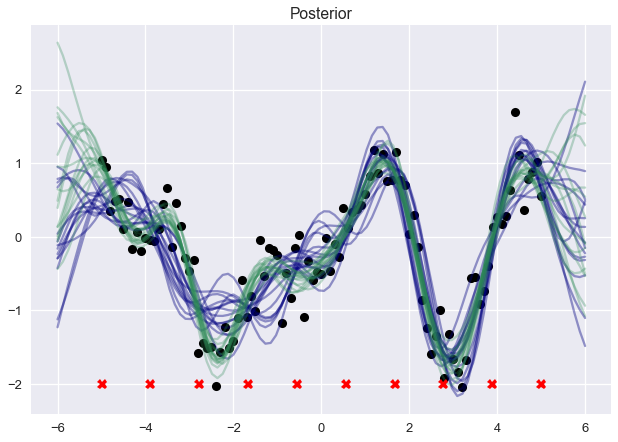

In [94]:
plt.plot(X.flatten(), y.flatten(), 'ko');

plt.plot(Z.flatten(), samples_u.T, 'Navy', alpha=0.4);
plt.plot(Z.flatten(), samples_full.T, 'SeaGreen', alpha=0.3);
plt.title("Posterior")
    
plt.plot(Xu.flatten(), -2 * np.ones(Xu.shape[0]), "X", color='r', ms=10);

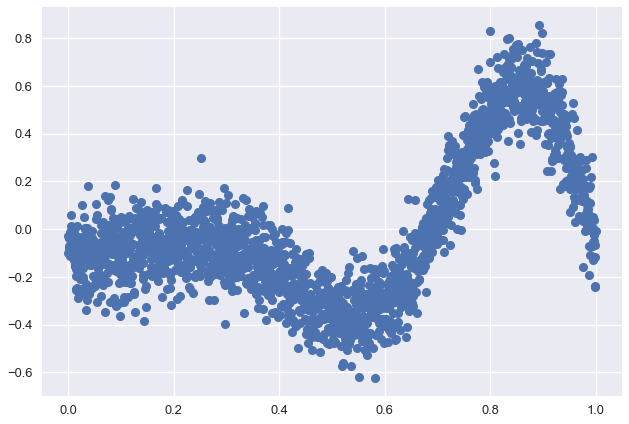

In [95]:
nx = 2000
x = np.linspace(0,1,nx)
y = x*x * np.sin(2*np.pi*1.5*x) + 0.1*np.random.randn(nx)
y = y - np.mean(y)
plt.plot(x, y, 'o');

Z = np.linspace(0,1,100)[:,None]
Xu = np.linspace(0,1,6)[:,None]
X = x[:,None]

In [96]:
with pm.Model() as model:
    l = pm.HalfCauchy("l", beta=5, testval=0.2)
    sf2 = pm.HalfCauchy("sf2", beta=5, testval=1.0)
    sn2 = pm.HalfCauchy("sn2", beta=5, testval=0.2)
    
    cov = pm.gp.cov.ExpQuad(1, l) * sf2
    mu = pm.gp.mean.Zero()
    
    # with inducing points
    gp = pm.gp.gp.GPfitc("gp", mean_func=mu, cov_func=cov, X=X, inducing_points=Xu, sigma2=sn2, observed=y)

with model:
    approx = pm.find_MAP(live_disp=True, fmin=sp.optimize.fmin_l_bfgs_b)

In [97]:
with model:
    samples = pm.gp.gp.sample_gp([approx]*5, gp, Z, progressbar=True, obs_noise=False)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


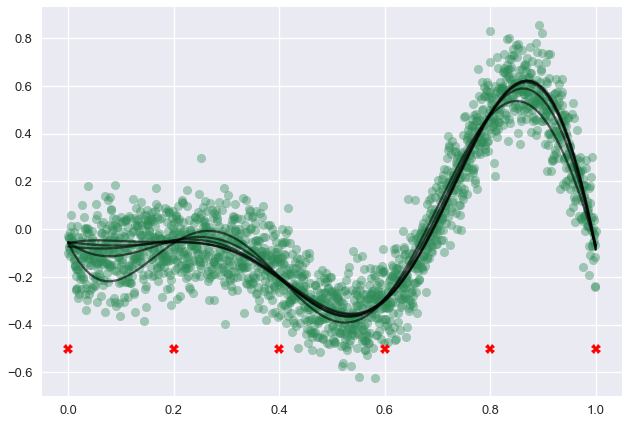

In [98]:
plt.plot(X.flatten(), y.flatten(), 'o', color='SeaGreen', alpha=0.4);

plt.plot(Z.flatten(), samples.T, color='k', alpha=0.6)
    
plt.plot(Xu.flatten(), -0.5 * np.ones(Xu.shape[0]), "X", color='r');

In [99]:
{param[:param.find('_')]: np.exp(approx[param]) for param in approx}

{'l': 0.36094485466031118,
 'sf2': 18.302754110612156,
 'sn2': 0.0097714701114201205}

### Multidimensional GP

Until now, our examples have been of 1-dimensional Gaussian processes, where there is just a single predictor variable thought to have a non-linear relationship to the outcome. Let's look at a real-world dataset that involves two predictors. We will use the famous **Walker Lake dataset (Isaaks & Srivistava 1989)** that involves spatial sampling of minerals and other variables over space. The data consist of two spatial coordinates and three measured outcomes. The outcomes are anonymously labeled as U, V (continuous variables, such as concentrarion) and T (discrete variable, such as the presence of a particular element). 

In [42]:
walker_data = pd.read_table('data/walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
              names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
walker_data.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


The samples are taken regularly over a coarse grid across the entire area, and then irregularly over portions of the area, presumably where there were positive samples on the coarser grid. 

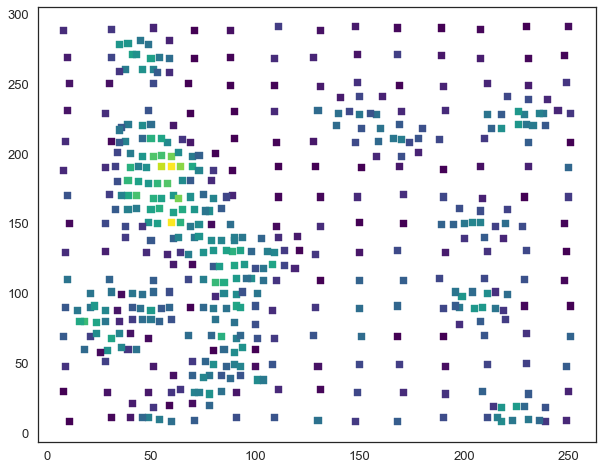

In [43]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = walker_data[['Xloc', 'Yloc']].values
y_obs = walker_data.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(X_obs[:,0], X_obs[:,1], s=50, c=y_obs, marker='s', cmap=plt.cm.viridis);

In [44]:
# denser grid to predict on
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

# grid of inducing points
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [45]:
with pm.Model() as model:
    l = pm.HalfCauchy("l", beta=5, shape=(2,), testval=np.array([0.2, 0.4]))
    sf2 = pm.HalfCauchy("sf2", beta=5, testval=1.0)
    sn2 = pm.HalfCauchy("sn2", beta=5, testval=0.2)

    cov = pm.gp.cov.ExpQuad(2, l) * sf2
    mu = pm.gp.mean.Zero()
    gp = pm.gp.gp.GPfitc("yobs", mean_func=mu, cov_func=cov, X=X_obs, inducing_points=Xu, sigma2=sn2, observed=y_obs)

with model:
    start = pm.find_MAP(live_disp=True, fmin=sp.optimize.fmin_l_bfgs_b)

In [46]:
with model:
    samples = pm.gp.gp.sample_gp([start]*2, gp, Z, obs_noise=False)

100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


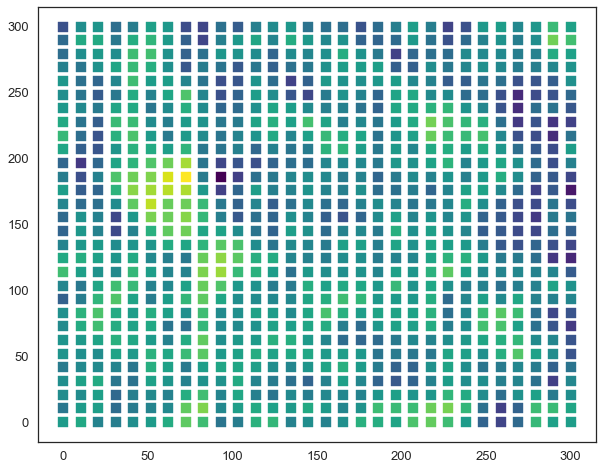

In [47]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    plt.scatter(z1.flatten(), z2.flatten(), s=100, c=samples[0,:], marker='s', cmap=plt.cm.viridis);